In [26]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections
import pandas as pd
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

# Get Data

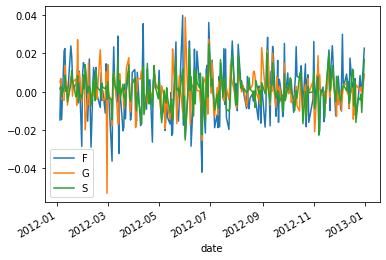

In [10]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()

# Combine Seperate DFs into one
ret_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v.sort_index(ascending = True, inplace = True)
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    ret_df = pd.concat([ret_df , v[["ret"]]] , axis = 1)
    
ret_df.columns = data.keys()
ret_df.plot()

# 1. Model with just local linear trend

## 1.1 Build Model

In [13]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    model = sts.Sum([trend], observed_time_series=observed_time_series)
    return model

model_llt = build_model(ret_df["S"].values)

## 1.2 Train

In [17]:
num_variational_steps = 200 
num_variational_steps = int(num_variational_steps)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model_llt)
optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train(observed_time_series):
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn = model_llt.joint_log_prob(
                                        observed_time_series=observed_time_series),
                                        surrogate_posterior=variational_posteriors,
                                        optimizer=optimizer,
                                        num_steps=num_variational_steps)
    return elbo_loss_curve

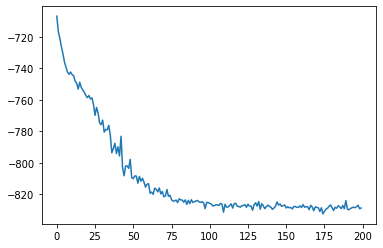

In [19]:
# Minimize the variational loss.
elbo_loss_curve = train(ret_df["S"].values)
plt.plot(elbo_loss_curve)
plt.show()

## 1.3 Sample

In [20]:
# Draw samples from the variational posterior.
sample_llt = variational_posteriors.sample(50)
print("Inferred parameters:")
for param in model_llt.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(sample_llt[param.name], axis=0),
                              np.std(sample_llt[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.00805428951517105 +- 0.0004317085453519869
LocalLinearTrend/_level_scale: 0.00020154952196893835 +- 0.00013107824462012434
LocalLinearTrend/_slope_scale: 4.0442224699377225e-06 +- 4.11022588551468e-06


# 1.4 Forecast and simulate

In [48]:
num_forecast_steps = 100
num_samples= 100
forecast_dist = tfp.sts.forecast(
    model_llt,
    observed_time_series = ret_df["S"].values,
    parameter_samples = sample_llt,
    num_steps_forecast=num_forecast_steps)


forecast_mean, forecast_scale, forecast_samples = (
                    forecast_dist.mean().numpy()[..., 0],
                    forecast_dist.stddev().numpy()[..., 0],
                    forecast_dist.sample(num_samples).numpy()[..., 0])

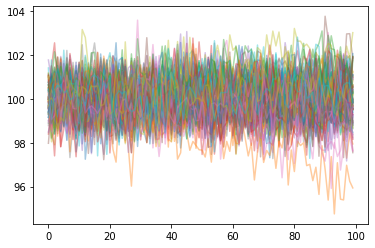

In [49]:
for i in range( forecast_samples.shape[0]):
    path = [100 * (1 + r) for r in forecast_samples[i,:]]
    plt.plot(path , alpha = 0.4 )